# Chapter 7

Zachary Campbell, Week 7 Assignment 2 -- 7.1, 8.1 and 8.2 (7.1 below)


In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [2]:
import numpy as np


import thinkstats2
import thinkplot

## Scatter plots

I'll start with the data from the BRFSS again.

In [3]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [4]:
import brfss


df = brfss.ReadBrfss(nrows=None)

The following function selects a random subset of a `DataFrame`.

In [5]:
def SampleRows(df, nrows, replace=False):
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

I'll extract the height in cm and the weight in kg of the respondents in the sample.

In [6]:
sample = SampleRows(df, 5000)
heights, weights = sample.htm3, sample.wtkg2

Here's a simple scatter plot with `alpha=1`, so each data point is fully saturated.

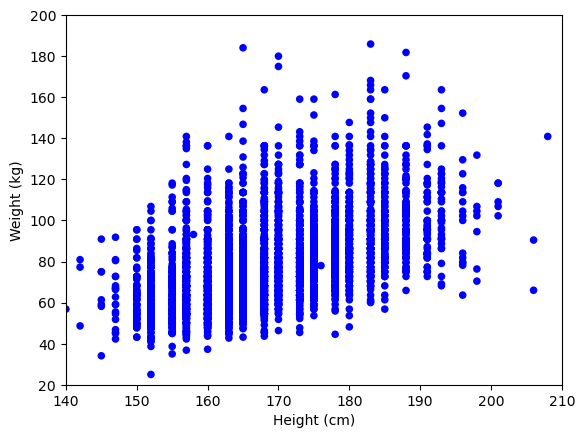

In [7]:
thinkplot.Scatter(heights, weights, alpha=1)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

The data fall in obvious columns because they were rounded off.  We can reduce this visual artifact by adding some random noise to the data.

NOTE: The version of `Jitter` in the book uses noise with a uniform distribution.  Here I am using a normal distribution.  The normal distribution does a better job of blurring artifacts, but the uniform distribution might be more true to the data.

In [8]:
def Jitter(values, jitter=0.5):
    n = len(values)
    return np.random.normal(0, jitter, n) + values

Heights were probably rounded off to the nearest inch, which is 2.6 cm, so I'll add random values from -1.3 to 1.3.

In [9]:
heights = Jitter(heights, 1.3)
weights = Jitter(weights, 0.5)

And here's what the jittered data look like.

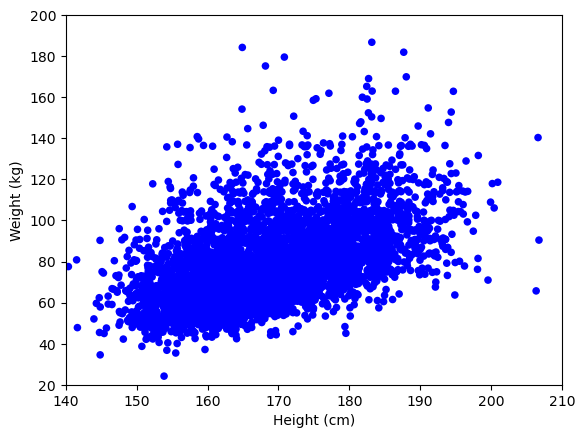

In [10]:
thinkplot.Scatter(heights, weights, alpha=1.0)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

The columns are gone, but now we have a different problem: saturation.  Where there are many overlapping points, the plot is not as dark as it should be, which means that the outliers are darker than they should be, which gives the impression that the data are more scattered than they actually are.

This is a surprisingly common problem, even in papers published in peer-reviewed journals.

We can usually solve the saturation problem by adjusting `alpha` and the size of the markers, `s`.

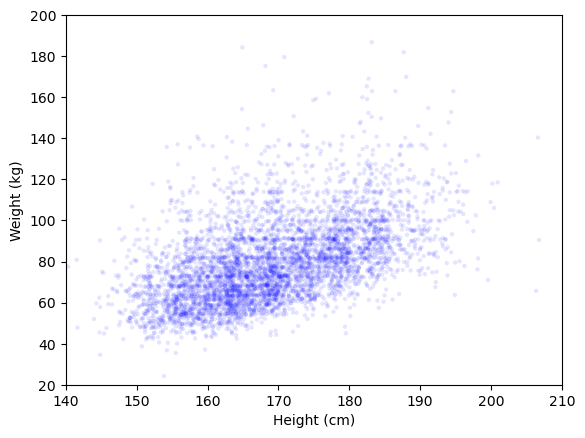

In [11]:
thinkplot.Scatter(heights, weights, alpha=0.1, s=10)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

That's better.  This version of the figure shows the location and shape of the distribution most accurately.  There are still some apparent columns and rows where, most likely, people reported their height and weight using rounded values.  If that effect is important, this figure makes it apparent; if it is not important, we could use more aggressive jittering to minimize it. 

An alternative to a scatter plot is something like a `HexBin` plot, which breaks the plane into bins, counts the number of respondents in each bin, and colors each bin in proportion to its count.

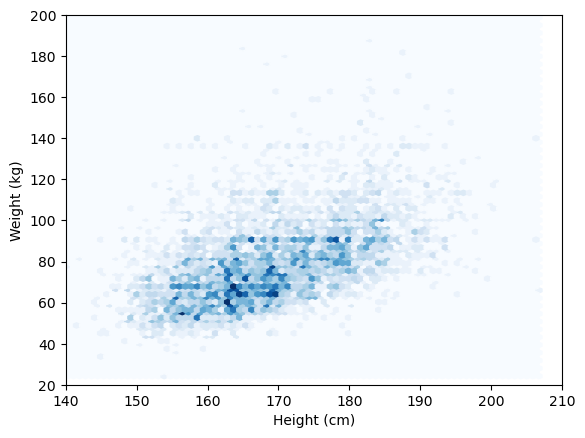

In [12]:
thinkplot.HexBin(heights, weights)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

In this case the binned plot does a pretty good job of showing the location and shape of the distribution.  It obscures the row and column effects, which may or may not be a good thing.

**Exercise:**  So far we have been working with a subset of only 5000 respondents.  When we include the entire dataset, making an effective scatter plot can be tricky.  As an exercise, experiment with `Scatter` and `HexBin` to make a plot that represents the entire dataset well.

## Plotting percentiles

Sometimes a better way to get a sense of the relationship between variables is to divide the dataset into groups using one variable, and then plot percentiles of the other variable.

First I'll drop any rows that are missing height or weight.

In [13]:
cleaned = df.dropna(subset=['htm3', 'wtkg2'])

Then I'll divide the dataset into groups by height.

In [14]:
bins = np.arange(135, 210, 5)
indices = np.digitize(cleaned.htm3, bins)
groups = cleaned.groupby(indices)

Here are the number of respondents in each group:

In [15]:
for i, group in groups:
    print(i, len(group))

0 305
1 228
2 477
3 2162
4 18759
5 45761
6 70610
7 72138
8 61725
9 49938
10 43555
11 20077
12 7784
13 1777
14 405
15 131


Now we can compute the CDF of weight within each group.

In [16]:
mean_heights = [group.htm3.mean() for i, group in groups]
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups]

And then extract the 25th, 50th, and 75th percentile from each group.

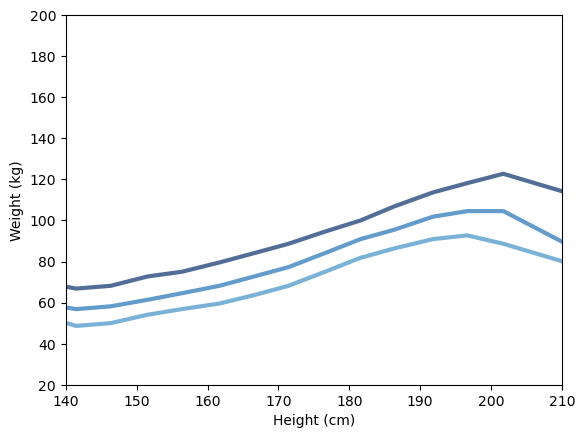

In [17]:
for percent in [75, 50, 25]:
    weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(mean_heights, weight_percentiles, label=label)
    
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

**Exercise:** Yet another option is to divide the dataset into groups and then plot the CDF for each group.  As an exercise, divide the dataset into a smaller number of groups and plot the CDF for each group.

## Correlation

The following function computes the covariance of two variables using NumPy's `dot` function.

In [18]:
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

And here's an example:

In [19]:
heights, weights = cleaned.htm3, cleaned.wtkg2
Cov(heights, weights)

103.33290857697797

Covariance is useful for some calculations, but it doesn't mean much by itself.  The coefficient of correlation is a standardized version of covariance that is easier to interpret.

In [20]:
def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

The correlation of height and weight is about 0.51, which is a moderately strong correlation.

In [21]:
Corr(heights, weights)

0.5087364789734665

NumPy provides a function that computes correlations, too:

In [22]:
np.corrcoef(heights, weights)

array([[1.        , 0.50873648],
       [0.50873648, 1.        ]])

The result is a matrix with self-correlations on the diagonal (which are always 1), and cross-correlations on the off-diagonals (which are always symmetric).

Pearson's correlation is not robust in the presence of outliers, and it tends to underestimate the strength of non-linear relationships.

Spearman's correlation is more robust, and it can handle non-linear relationships as long as they are monotonic.  Here's a function that computes Spearman's correlation:

In [23]:
import pandas as pd

def SpearmanCorr(xs, ys):
    xranks = pd.Series(xs).rank()
    yranks = pd.Series(ys).rank()
    return Corr(xranks, yranks)

For heights and weights, Spearman's correlation is a little higher:

In [24]:
SpearmanCorr(heights, weights)

0.5405846262320475

A Pandas `Series` provides a method that computes correlations, and it offers `spearman` as one of the options.

In [25]:
def SpearmanCorr(xs, ys):
    xs = pd.Series(xs)
    ys = pd.Series(ys)
    return xs.corr(ys, method='spearman')

The result is the same as for the one we wrote.

In [26]:
SpearmanCorr(heights, weights)

0.5405846262320457

An alternative to Spearman's correlation is to transform one or both of the variables in a way that makes the relationship closer to linear, and the compute Pearson's correlation.

In [27]:
Corr(cleaned.htm3, np.log(cleaned.wtkg2))

0.5317282605983543

## Exercises

Using data from the NSFG, make a scatter plot of birth weight versus mother’s age. Plot percentiles of birth weight versus mother’s age. Compute Pearson’s and Spearman’s correlations. How would you characterize the relationship between these variables?

In [28]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [29]:
import first
import pandas

live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])

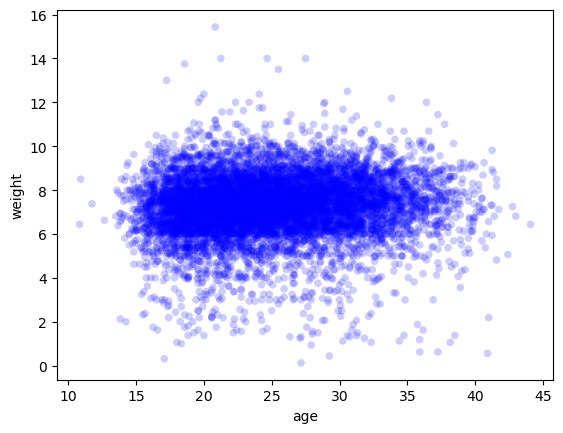

In [30]:
thinkplot.Scatter(live.agepreg,live.totalwgt_lb)
thinkplot.Config(xlabel='age', ylabel='weight')

In [31]:
binned_age = pandas.cut(live.agepreg, bins=12, retbins=True)
def BinnedPercentiles(df):
    bins = np.arange(10,48,3)
    indices = np.digitize(df.agepreg,bins)
    groups = df.groupby(indices)
    ages = [group.agepreg.mean() for i, group in groups][1:-1]
    cdfs = [thinkstats2.Cdf(group.totalwgt_lb) for i, group in groups][1:-1]
    thinkplot.PrePlot(3)
    for percent in [75,50,25]:
        weights = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(ages, weights, label=label)
    thinkplot.Save(root='chap07scatter3', formats=['jpg'], xlabel="mother's age(years)",ylabel='birth weight (lbs)')
    

In [32]:
BinnedPercentiles(live)

Writing chap07scatter3.jpg


<Figure size 800x600 with 0 Axes>

In [33]:
ages = live.agepreg
weights = live.totalwgt_lb
print ('TS Corr', round(thinkstats2.Corr(ages, weights), 3))
print ('TS Sprearman Corr', round(thinkstats2.SpearmanCorr(ages, weights), 3))

TS Corr 0.069
TS Sprearman Corr 0.095


# Chapter 8

Zachary Campbell, Week 7 Assignment 2 -- 7.1, 8.1 and 8.2 (8.1,8.2 below)


In [34]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [35]:
import numpy as np

import thinkstats2
import thinkplot

## The estimation game


Root mean squared error is one of several ways to summarize the average error of an estimation process.

In [36]:
def RMSE(estimates, actual):
    """Computes the root mean squared error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float RMSE
    """
    e2 = [(estimate-actual)**2 for estimate in estimates]
    mse = np.mean(e2)
    return np.sqrt(mse)

The following function simulates experiments where we try to estimate the mean of a population based on a sample with size `n=7`.  We run `iters=1000` experiments and collect the mean and median of each sample.

In [37]:
import random

def Estimate1(n=7, iters=1000):
    """Evaluates RMSE of sample mean and median as estimators.

    n: sample size
    iters: number of iterations
    """
    mu = 0
    sigma = 1

    means = []
    medians = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for _ in range(n)]
        xbar = np.mean(xs)
        median = np.median(xs)
        means.append(xbar)
        medians.append(median)

    print('Experiment 1')
    print('rmse xbar', RMSE(means, mu))
    print('rmse median', RMSE(medians, mu))
    
Estimate1()

Experiment 1
rmse xbar 0.3860686073564951
rmse median 0.47960545337074884


Using $\bar{x}$ to estimate the mean works a little better than using the median; in the long run, it minimizes RMSE.  But using the median is more robust in the presence of outliers or large errors.


## Estimating variance

The obvious way to estimate the variance of a population is to compute the variance of the sample, $S^2$, but that turns out to be a biased estimator; that is, in the long run, the average error doesn't converge to 0.

The following function computes the mean error for a collection of estimates.

In [38]:
def MeanError(estimates, actual):
    """Computes the mean error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float mean error
    """
    errors = [estimate-actual for estimate in estimates]
    return np.mean(errors)

The following function simulates experiments where we try to estimate the variance of a population based on a sample with size `n=7`.  We run `iters=1000` experiments and two estimates for each sample, $S^2$ and $S_{n-1}^2$.

In [39]:
def Estimate2(n=7, iters=1000):
    mu = 0
    sigma = 1

    estimates1 = []
    estimates2 = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        biased = np.var(xs)
        unbiased = np.var(xs, ddof=1)
        estimates1.append(biased)
        estimates2.append(unbiased)

    print('mean error biased', MeanError(estimates1, sigma**2))
    print('mean error unbiased', MeanError(estimates2, sigma**2))
    
Estimate2()

mean error biased -0.1301702457028781
mean error unbiased 0.014801380013308869


The mean error for $S^2$ is non-zero, which suggests that it is biased.  The mean error for $S_{n-1}^2$ is close to zero, and gets even smaller if we increase `iters`.

## The sampling distribution

The following function simulates experiments where we estimate the mean of a population using $\bar{x}$, and returns a list of estimates, one from each experiment.

In [40]:
def SimulateSample(mu=90, sigma=7.5, n=9, iters=1000):
    xbars = []
    for j in range(iters):
        xs = np.random.normal(mu, sigma, n)
        xbar = np.mean(xs)
        xbars.append(xbar)
    return xbars

xbars = SimulateSample()

Here's the "sampling distribution of the mean" which shows how much we should expect $\bar{x}$ to vary from one experiment to the next.

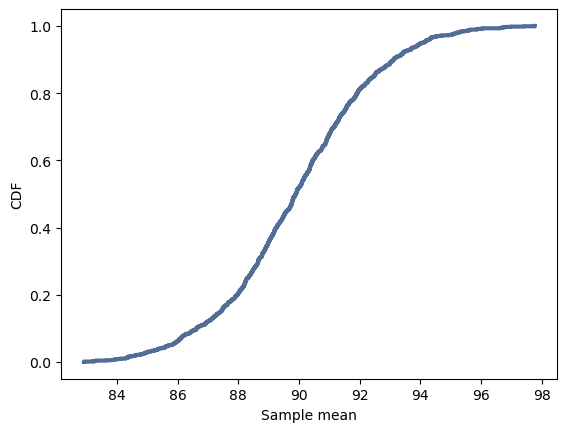

In [41]:
cdf = thinkstats2.Cdf(xbars)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Sample mean',
                 ylabel='CDF')

The mean of the sample means is close to the actual value of $\mu$.

In [42]:
np.mean(xbars)

89.91350973341136

An interval that contains 90% of the values in the sampling disrtribution is called a 90% confidence interval.

In [43]:
ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(85.70939286051723, 94.06666336769047)

And the RMSE of the sample means is called the standard error.

In [44]:
stderr = RMSE(xbars, 90)
stderr

2.491072042830942

Confidence intervals and standard errors quantify the variability in the estimate due to random sampling.

## Estimating rates

The following function simulates experiments where we try to estimate the mean of an exponential distribution using the mean and median of a sample. 

In [45]:
def Estimate3(n=7, iters=1000):
    lam = 2

    means = []
    medians = []
    for _ in range(iters):
        xs = np.random.exponential(1.0/lam, n)
        L = 1 / np.mean(xs)
        Lm = np.log(2) / thinkstats2.Median(xs)
        means.append(L)
        medians.append(Lm)

    print('rmse L', RMSE(means, lam))
    print('rmse Lm', RMSE(medians, lam))
    print('mean error L', MeanError(means, lam))
    print('mean error Lm', MeanError(medians, lam))
    
Estimate3()

rmse L 1.168630778871458
rmse Lm 1.6999811742283886
mean error L 0.3437601032295432
mean error Lm 0.44746485891458204


The RMSE is smaller for the sample mean than for the sample median.

But neither estimator is unbiased.

## Exercises

**Exercise:**  In this chapter we used $\bar{x}$ and median to estimate µ, and found that $\bar{x}$ yields lower MSE. Also, we used $S^2$ and $S_{n-1}^2$ to estimate σ, and found that $S^2$ is biased and $S_{n-1}^2$ unbiased.
Run similar experiments to see if $\bar{x}$ and median are biased estimates of µ. Also check whether $S^2$ or $S_{n-1}^2$ yields a lower MSE.

In [46]:
def Estimate4(n=7, iters=100000):
    """Mean error for xbar and median as estimators of population mean.

    n: sample size
    iters: number of iterations
    """
    mu = 0
    sigma = 1

    means = []
    medians = []
    for x in range(iters):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        xbar = np.mean(xs)
        median = np.median(xs)
        means.append(xbar)
        medians.append(median)

    print('Experiment 4')
    print('mean error xbar:', MeanError(means, mu))
    print('mean error median:', MeanError(medians, mu))
    
Estimate4()

Experiment 4
mean error xbar: -0.0022969090565045066
mean error median: -0.0024838330700608533


In [47]:
def Estimate5(n=7, iters=100000):
    """RMSE for biased and unbiased estimators of population variance.

    n: sample size
    iters: number of iterations
    """
    mu = 0
    sigma = 1

    estimates1 = []
    estimates2 = []
    for x in range(iters):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        biased = np.var(xs)
        unbiased = np.var(xs, ddof=1)
        estimates1.append(biased)
        estimates2.append(unbiased)

    print('Experiment 5')
    print('RMSE biased:', RMSE(estimates1, sigma**2))
    print('RMSE unbiased:', RMSE(estimates2, sigma**2))

Estimate5()

Experiment 5
RMSE biased: 0.5182538229545728
RMSE unbiased: 0.5811079700767438


Conclusions:
Based on the xbar and median mean error decreasing as m increases it indicates that neither is biased based on the experiment. Further the biased estimator of variance yields lower RMSE than the unbiased estimator and that difference is consistent as m increases.

**Exercise:** Suppose you draw a sample with size n=10 from an exponential distribution with λ=2. Simulate this experiment 1000 times and plot the sampling distribution of the estimate L. Compute the standard error of the estimate and the 90% confidence interval.

Repeat the experiment with a few different values of `n` and make a plot of standard error versus `n`.



standard error 0.7987007634850464
confidence interval (1.2595183029872548, 3.752346495897427)


0.7987007634850464

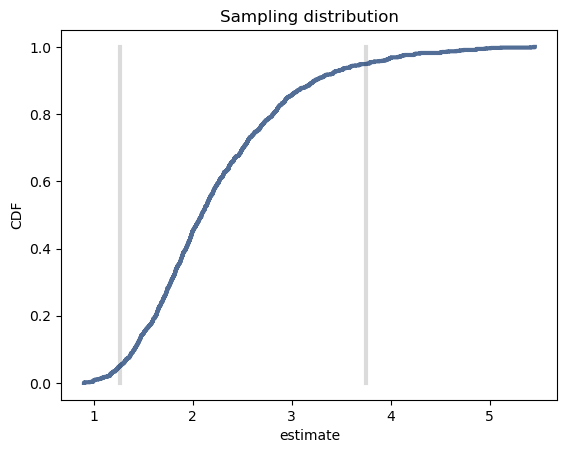

In [48]:
def SampleSim(lam=2, n=10, iters=1000):
    """Sampling distribution of L as an estimator of exponential parameter.

    lam: parameter of an exponential distribution
    n: sample size
    iters: number of iterations
    """
    def VLine(x, y=1):
        thinkplot.Plot([x, x], [0, y], color='0.8', linewidth=3)

    estimates = []
    for _ in range(iters):
        xs = np.random.exponential(1.0/lam, n)
        lamhat = 1.0 / np.mean(xs)
        estimates.append(lamhat)

    stderr = RMSE(estimates, lam)
    print('standard error', stderr)

    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.Percentile(5), cdf.Percentile(95)
    print('confidence interval', ci)
    VLine(ci[0])
    VLine(ci[1])

    # plot the CDF
    thinkplot.Cdf(cdf)
    thinkplot.Config(xlabel='estimate',
                     ylabel='CDF',
                     title='Sampling distribution')

    return stderr

SampleSim()

Conclusion:
With a sample size of 10, the standard error was 0.8034673142250264 with a confidence interval of (1.2578596540209634, 3.7247087585877052). As the sample size increases, the standard error and the width of the confidence interval decreases. For example sample size of 100 results in a standard error of 0.19991562482269296 and confidence interval of(1.7046533274034754, 2.379769215263324). Further a sample size of 1000 results in a standard error of 0.06262418497247063 and confidence interval of (1.8957200709914934, 2.1029688625303886). All of which include the value of 2.